<a href="https://colab.research.google.com/github/tblackfd/Thesis/blob/main/BrandtModelReplication_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background
This notebook intends to replicate the Lifecycle Assessment of geologic hydrogen produced by Brandt (2023) in order to perform a review of its methods and assumptions, as well as the conclusions published in the associated paper.

In [27]:
#Import relevant packages

import pandas as pd
import numpy as np
import matplotlib as plt
import math

# Input Data Specific to Geologic H2

The following section establishes input data specific to the estimation of emissions from production of geologic hydrogen.

Key assumptions are:
* Well pressure calculated as depth (in ft) by a factor 0.42
* Initial Baseline raw gas rate is given (23,100 MSCFD) and declines at a manually-defined rate.
* Low pressure case is assumed to be 75% of baseline
* High pressure case is assumed to be 125% of baseline
* "High productivity" wellhead pressure is assumed to be 200% of baseline
* "Deep" and "Shallow" pressures are calculated based on assumed depths of 12,000 and 1,500 ft, respectively.

# Constants/Assumptions for Calculations

In [46]:
GWP_H2 = 5 #Global Warming Potential of H2, relative to CO2, to enable CO2e calculations. From Brandt OPGEE file: "Low value from Derwent et al. 2020, of 5.0. High value of 10.9 from Warwick et al. 2022."
GWP_CH4 = 25 #Global Warming Potential of methane. 100-year basis, IPCC 2007 AR4, per Brand OPGEE file.

LHV_H2 = 113.958057395143 #mmbtu/tonne. OPGEE source listed as Mechanical engineer's handbook - Energy & Power (3rd edition). John Wiley & Sons. Chapter 17: Gaseous Fuels, Table 2
LHV_CH4 = 47.5055187637969 #mmbtu/tonne

#LHV Energy Densities for gases:
data = {
    'Gas': ['N2', 'O2', 'CO2', 'H2O', 'CH4', 'C2H6', 'C3H8', 'C4H10', 'CO', 'H2', 'H2S', 'SO2'],
    'LHV (MJ/kg)': [
        0.0000000000,  # LHV for N2, Ar
        0.0000000000,  # LHV for O2
        0.0000000000,  # LHV for CO2
        0.0000000000,  # LHV for H2O
        50.1206975717,  # LHV for CH4
        47.5867143488,  # LHV for C2H6
        46.4501483444,  # LHV for C3H8
        45.8352847682,  # LHV for C4H10
        10.1242877483,  # LHV for CO
        120.2314484547,  # LHV for H2
        15.2434928256,  # LHV for H2S
        0.0000000000   # LHV for SO2
    ]
}
# Create the DataFrame
LHV_density_gases_metric = pd.DataFrame(data)
# Set 'Gas' as the index instead of a column
LHV_density_gases_metric.set_index('Gas', inplace=True)



# Key Variables / Inputs

In [3]:
### Gas Densities. Define a dataframe:

# Define the data as a dictionary
data = {
    'Gas': ['N2','CO2', 'CH4', 'H2'],
    'Density tonne/MMSCF': [33.480353, 52.605153, 19.1738073, 2.4097248]
}

# Create the DataFrame
gas_densities = pd.DataFrame(data)

# Set 'Gas' as the index instead of a column
gas_densities.set_index('Gas', inplace=True)

#Assume all cases produce 0.1 bbl/day of oil:
oil_production_baseline = 0.1 #bbl/day

field_lifespan = 30 #years

# Define/Assume Reservoir Conditions for Analysis

In [4]:
# Data for the Reservoir Conditions DataFrame
reservoir_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'Raw Gas EUR, BCF': [67, 33, 167, 67, 67, 33, 67, 67, 67, 67, 33],
    'H2 EUR, BCF': [57, 28, 142, 57, 57, 28, 57, 57, 57, 57, 28],
    'Depth, ft': [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 12000, 1500],
    'Initial Reservoir Pressure, psi': [2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 5040, 630]
}

# Data for the Gas Composition DataFrame
gas_composition_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'H2': [85.0, 85.0, 85.0, 85.0, 85.0, 75.0, 75.0, 75.0, 95.0, 85.0, 85.0],
    'N2': [12.0, 12.0, 12.0, 1.5, 8.5, 20.0, 0.0, 22.5, 4.0, 12.0, 12.0],
    'CH4': [1.5, 1.5, 1.5, 12.0, 5.0, 2.5, 22.5, 0.0, 0.5, 1.5, 1.5],
    'C2+': [0.0] * 11,
    'CO2': [0.0] * 11,
    'Ar/oth inert': [1.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 0.5, 1.5, 1.5]
}

# Data for the Development Parameters DataFrame
development_params_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'Total Producing Wells': [50] * 11,
    'No. of Compressors': [2] * 11,
    'No. of Purification Plants': [1] * 11,
    'Water Cut (bbl/mmscf)': [1] * 11,
    'H2 purification loss rate': [10] * 11,
    'BCF per well': [1.3, 0.33, 2.0, 1.0, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.0]
}

# Creating the DataFrames & setting 'Case' as the index to make slicing based on Case easier
reservoir_df = pd.DataFrame(reservoir_data)
reservoir_df.set_index('Case', inplace=True)

gas_composition_df = pd.DataFrame(gas_composition_data)
gas_composition_df.set_index('Case', inplace=True)

development_params_df = pd.DataFrame(development_params_data)
development_params_df.set_index('Case', inplace=True)

# # Display the DataFrames (Optional)
# print("Reservoir Conditions DataFrame:")
# print(reservoir_df)
# print("\nGas Composition DataFrame:")
# print(gas_composition_df)
# print("\nDevelopment Parameters DataFrame:")
# print(development_params_df)


In [5]:
#Now define the assumed production profile over the life of each well

# Constants
pressure_coefficient = 0.42
pressure_decline_rate = 0.95
rate_decline_factors = np.array([
    0.3, 0.2, 0.15, 0.125, 0.125, 0.1, 0.1, 0.09, 0.08, 0.07,
    0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03,
    0.03, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02
])
rate_decline_factors = rate_decline_factors[:30]  # Ensure it has exactly 30 elements

# Extract depths for Baseline, Deep, and Shallow from the reservoir_df
depths = reservoir_df['Depth, ft']

# Initial values calculated by depth
initial_wellhead_pressure_baseline = depths['Baseline'] * pressure_coefficient
initial_deep_pressure = depths['Deep'] * 0.43
initial_shallow_pressure = depths['Shallow'] * 0.43

# DataFrame initialization
df = pd.DataFrame({
    'Year': range(1, 31),
    'Baseline Raw Gas Rate, MSCFD': [23100] * 30,  # Baseline raw gas rate
    'Baseline Wellhead Pressure, PSI': [initial_wellhead_pressure_baseline] * 30,
    'Deep Pressure, PSI': [initial_deep_pressure] * 30,
    'Shallow Pressure, PSI': [initial_shallow_pressure] * 30
})

# Calculate the baseline raw gas rate and wellhead pressure for each year
for year in range(1, 30):  # Skip the first year as the initial values are already set
    df.loc[year, 'Baseline Raw Gas Rate, MSCFD'] = df.loc[year - 1, 'Baseline Raw Gas Rate, MSCFD'] * (1 - rate_decline_factors[year-1])
    df.loc[year, 'Baseline Wellhead Pressure, PSI'] = df.loc[year - 1, 'Baseline Wellhead Pressure, PSI'] * pressure_decline_rate
    df.loc[year, 'Deep Pressure, PSI'] = df.loc[year - 1, 'Deep Pressure, PSI'] * pressure_decline_rate
    df.loc[year, 'Shallow Pressure, PSI'] = df.loc[year - 1, 'Shallow Pressure, PSI'] * pressure_decline_rate

# Update other pressures based on the baseline wellhead pressure
df['Low Pressure Wellhead Pressure, PSI'] = df['Baseline Wellhead Pressure, PSI'] * 0.75
df['High Pressure Wellhead Pressure, PSI'] = df['Baseline Wellhead Pressure, PSI'] * 1.25

# Update the low and high productivity raw gas rate values
df['Low Productivity Raw Gas Rate, MSCFD'] = df['Baseline Raw Gas Rate, MSCFD'] * 0.25
df['High Productivity Raw Gas Rate, MSCFD'] = df['Baseline Raw Gas Rate, MSCFD'] * 2

# Calculate the baseline Gas Oil Ratio (GOR)
df['Baseline GOR, SCF/BBL'] = df['Baseline Raw Gas Rate, MSCFD'] * 1000 / oil_production_baseline

# Print the DataFrame
df.head()

/var/folders/qy/z7337b5132l170hg74tn22yw0000gn/T/ipykernel_22627/349184173.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16169.999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[year, 'Baseline Raw Gas Rate, MSCFD'] = df.loc[year - 1, 'Baseline Raw Gas Rate, MSCFD'] * (1 - rate_decline_factors[year-1])


,Year,"Baseline Raw Gas Rate, MSCFD","Baseline Wellhead Pressure, PSI","Deep Pressure, PSI","Shallow Pressure, PSI","Low Pressure Wellhead Pressure, PSI","High Pressure Wellhead Pressure, PSI","Low Productivity Raw Gas Rate, MSCFD","High Productivity Raw Gas Rate, MSCFD","Baseline GOR, SCF/BBL"
0,1,23100.00,2520.00000,5160.00000,645.000000,1890.000000,3150.000000,5775.0000,46200.0,231000000.0
1,2,16170.00,2394.00000,4902.00000,612.750000,1795.500000,2992.500000,4042.5000,32340.0,161700000.0
2,3,12936.00,2274.30000,4656.90000,582.112500,1705.725000,2842.875000,3234.0000,25872.0,129360000.0
3,4,10995.60,2160.58500,4424.05500,553.006875,1620.438750,2700.731250,2748.9000,21991.2,109956000.0
4,5,9621.15,2052.55575,4202.85225,525.356531,1539.416812,2565.694687,2405.2875,19242.3,96211500.0


# Sources of Emissions per Brandt Paper:
Brandt's paper considers that following categories of emissions contribute to the total emissions associated with a geologic hydrogen development:

1.  Operational Combustion
1.  Operational Venting, Flaring and Fugitive Emissions (VFF)
1.  Drilling energy-use and VFF
1.  Emissions embodied in wellbore construction materials and surface equipment
1.  "Other" offsite emissions
1.  "Small sources" of emissions, not significant enough to be modelled individually but included as course, aggregated estimates.

The following sections will consider each of these emissions categories and replicate the accounting for these sources.







# 1: Operational Combustion Emissions (kg CO2e/d)

Total operational combustion emissions are those associated with combustion during operation. These are only relevant in certain cases. In the baseline case, it is assumed that a portion of the produced H2 is used to provide power for compression (both upstream of gas treatment and upstream of waste gas re-injection), dehydration, and pressure-swing adsorption (PSA) separation.

Hydrogen combustion is assumed to have no CO2e emissions, so the baseline case has 0 Operational Combustion Emissions.

Other cases (e.g. high CH4 fields, where the CH4 is "self used" for the processes listed above) will have Operational Combustion Emissions. These will be assessed after replicating the baseline conditions.

In [6]:
baseline_operational_combustion_emissions = 0 #kg CO2e/d

# 2: Operational Venting, Flaring and Fugitive Emissions (VFF)

Brandt paper: "VFF emissions include all purposeful (vented) and un-purposeful (fugitive) emissions from process units and piping."

Each of sub-category (i.e. venting, flaring, or fugitive) is calculated individually, per each of the following process stages:

1.   Production & Extraction
2.   Surface Processing

The following two sub-categories are associated with VFF-type emissions, however these are separated out into a separate section. See Section 3, below.

3.   Exploration
4.   Drilling & Development

The following sub-categories are included in the full OPGEE analysis model, but are not considered relevant to geologic H2 production:

5.   Liquefied Natural Gas
6.   Maintenance
7.   Waste disposal
8.   Crude oil transport and storage
9.   Other Gas transport, storage, and distribution
10.  Electricity generation

Note also that the baseline case does not include any flaring, so it is sufficient to only consider Venting and Fugitive emissions for this specific case.

The following sections detail Venting and Flaring calculations for each of the relevant items above (i.e. Exploration and Drilling & Development).



### 2.1.1 Production & Extraction Venting

The OPGEE tool considers the following potential sources of vented emissions.

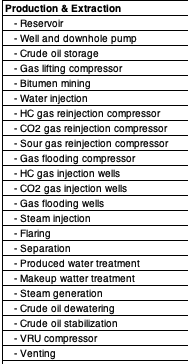

Of these, Brandt's baseline case shows emissions from the "Well and downhole pump", "HC gas reinjection compressor", "HC gas injection wells", and "Separation" process stages. Thus, these calculations are replicated below.

The basis of this calculation is to take the weighted sum (in terms of Global Warming Potential, i.e. ensuring CO2-equivalence) of emissions in each component associated with the "well & downhole pump" part of the system. These components are:


* Fugitives - Completions
 * 0.005%
 * $M$119
 * OPGEE labels this as fugitive, but logic actually classifies these emissions as vents
 * "Total gas lost during completions divided by gas production"
 * OPGEE uses a database of tonnes of fugitive emissions per activity in terms of CO2 and CH4. For Geologic H2, Brandt assumes that total mass of emissions per activity are consistent with the database values, but that the composition of the emissions are aligned with the assumptions regarding the reservoir composition (i.e. high H2, low CH4 and CO2).
* Fugitives - Workovers
 * "Total gas lost during workovers divided by gas production"
 * 0.0048%
 * $M$124
 * Assumes total gas for all workovers over field life and then calculates a loss rate as this total divided by total gas production. Loss is apportioned per reservoir composition.
* Pneumatic controllers
 * 0.0000%
 * $M$108
 * Loss rate calculated in same manner as wellhead, above.
* Liquids unloadings
 * * 0.1145%
 * $M$114
 * ???
 * This loss rate is dependent on gas rate, so needs to be calculated for each year of field life.
* On-site tanks - vents
 * 0.000% - No tanks in design.
 * $M$110



In [7]:
#First consider venting associated with completions. Calculate CH4 and H2 separately, then calculate their sum.
production_vent_completions_CH4 = 0.005/100 * GWP_CH4 * gas_composition_df.loc['Baseline', 'CH4']/100 * oil_production_baseline * df['Baseline GOR, SCF/BBL']/1E6 *gas_densities.loc['CH4','Density tonne/MMSCF'] #Loss Rate * GWP * Oil Rate * GOR * Density

production_vent_completions_H2 = 0.005/100 * GWP_H2 * gas_composition_df.loc['Baseline', 'H2']/100 * oil_production_baseline * df['Baseline GOR, SCF/BBL']/1E6 *gas_densities.loc['H2','Density tonne/MMSCF'] #Loss Rate * GWP * Oil Rate * GOR * Density

production_vent_completions = production_vent_completions_CH4 + production_vent_completions_H2 #This gives a series of 30 results. i.e. per year of field life.

#Now consider venting associated with workovers. Logic identical to above, but with a slightly different loss rate of 0.0048%
production_vent_workovers_CH4 = 0.0048/100 * GWP_CH4 * gas_composition_df.loc['Baseline', 'CH4']/100 * oil_production_baseline * df['Baseline GOR, SCF/BBL']/1E6 *gas_densities.loc['CH4','Density tonne/MMSCF'] #Loss Rate * GWP * Oil Rate * GOR * Density

production_vent_workovers_H2 = 0.0048/100 * GWP_H2 * gas_composition_df.loc['Baseline', 'H2']/100 * oil_production_baseline * df['Baseline GOR, SCF/BBL']/1E6 *gas_densities.loc['H2','Density tonne/MMSCF'] #Loss Rate * GWP * Oil Rate * GOR * Density

production_vent_workovers = production_vent_workovers_CH4 + production_vent_workovers_H2

#Now looking at the vents associated with Liquids Unloadings:

#Liquids unloadings vary according to rate of production from the field, so baseline loss rates have been extracted from Brandt's model for each year of field life:

liquids_unloadings_percentages = [
    0.022286, 0.035370, 0.045185, 0.045185, 0.047776, 0.069842, 0.075147, 0.075147, 0.075147,
    0.075147, 0.075147, 0.075147, 0.075147, 0.075147, 0.093191, 0.103238, 0.103238, 0.103238,
    0.103238, 0.114288, 0.114288, 0.114288, 0.114288, 0.114288, 0.114288, 0.114498, 0.114498,
    0.114498, 0.114498, 0.114498
]

# Create the DataFrame
df_liquids_unloadings = pd.DataFrame({
    'Year': range(1, 31),
    'Liquids Unloadings %': liquids_unloadings_percentages
})

production_vent_liquids_CH4 = df_liquids_unloadings['Liquids Unloadings %']/100 * GWP_CH4 * gas_composition_df.loc['Baseline', 'CH4']/100 * oil_production_baseline * df['Baseline GOR, SCF/BBL']/1E6 *gas_densities.loc['CH4','Density tonne/MMSCF'] #Loss Rate * GWP * Oil Rate * GOR * Density
production_vent_liquids_H2 = df_liquids_unloadings['Liquids Unloadings %']/100 * GWP_H2 * gas_composition_df.loc['Baseline', 'H2']/100 * oil_production_baseline * df['Baseline GOR, SCF/BBL']/1E6 *gas_densities.loc['H2','Density tonne/MMSCF'] #Loss Rate * GWP * Oil Rate * GOR * Density

production_vent_liquids = production_vent_liquids_CH4 + production_vent_liquids_H2

# print(production_vent_liquids)

### 2.1.2 Production & Extraction Fugitive

* Fugitives - Wellhead
 * 0.2754%
 *M99
 * Calculated as fractional loss rate. This loss rate is calculated as the average of emissions of this component under different flowrates (divided into 10 "tranches"), weighted against the relative volume of gas produced in each flowrate tranche.
* On-site meter
 * 0.1983%
 * $M$102
 * Loss rate calculated in same manner as wellhead, above.
* On-site dehydrator
 * 0.0103%
 * $M$103
 * Loss rate calculated in same manner as wellhead, above.
* On-site reciprocating compressor
 * 0.0338%
 * $M$104
 * Loss rate calculated in same manner as wellhead, above.
* On-site heater
 * 0.0168%
 * $M$105
 * Loss rate calculated in same manner as wellhead, above.
* On-site header
 * 0.0000%
 * $M$106
 * Loss rate calculated in same manner as wellhead, above.
* Chemical injection pumps
 * 0.0944%
 * $M$107
 * Loss rate calculated in same manner as wellhead, above.
* On-site tanks - leaks
 * 0.000% - No tanks in design.
 * $M$109






In [36]:
#Brandt's model shows that the loss rate at the well head increases as production decreases. These rates are extracted from Brandt's model as follows:

#Loss rates for this section are all based on flow rates downstream of the separator, so first calculate these rates. Create variables for all gases (CH4, H2, N2, CO2) downstream of the separator
#because these are required later, even if they are not considered for vented/fugitive emissions.

CH4_after_separator = (
    gas_composition_df.loc['Baseline', 'CH4'] / 100 *
    oil_production_baseline *
    df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['CH4', 'Density tonne/MMSCF']
)
H2_after_separator = (
    gas_composition_df.loc['Baseline', 'H2'] / 100 *
    oil_production_baseline *
    df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['H2', 'Density tonne/MMSCF']
)
N2_after_separator = (
    gas_composition_df.loc['Baseline', 'N2'] / 100 *
    oil_production_baseline *
    df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['N2', 'Density tonne/MMSCF']
)
CO2_after_separator = (
    gas_composition_df.loc['Baseline', 'CO2'] / 100 *
    oil_production_baseline *
    df['Baseline GOR, SCF/BBL'] / 1E6 *
    gas_densities.loc['CO2', 'Density tonne/MMSCF']
)

wellhead_fugitive_loss_rates = [
    0.073042, 0.102432, 0.130786, 0.130786, 0.134990, 0.179778, 0.195050, 0.195050, 0.195050,
    0.195050, 0.195050, 0.195050, 0.195050, 0.195050, 0.220065, 0.244452, 0.244452, 0.244452,
    0.244452, 0.274038, 0.274038, 0.274038, 0.274038, 0.274038, 0.274038, 0.274519, 0.274519,
    0.274519, 0.274519, 0.274519
]

# Create the DataFrame
df_wellhead_fugitive_loss_rates = pd.DataFrame({
    'Year': range(1, 31),
    'Wellhead Fugitive Losses %': wellhead_fugitive_loss_rates
})

production_fugitive_wellhead_CH4 = df_wellhead_fugitive_loss_rates['Wellhead Fugitive Losses %']/100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_wellhead_H2 = df_wellhead_fugitive_loss_rates['Wellhead Fugitive Losses %']/100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
production_fugitive_wellhead = production_fugitive_wellhead_CH4 + production_fugitive_wellhead_H2

### Now looking at the meter fugitive losses, which also change over the life of the field:

# Meter fugitive loss rates extracted from Brandt's model
meter_fugitive_loss_rates = [
    0.045713, 0.063821, 0.085305, 0.085305, 0.090005, 0.117416, 0.127744, 0.127744, 0.127744,
    0.127744, 0.127744, 0.127744, 0.127744, 0.127744, 0.152734, 0.164370, 0.164370, 0.164370,
    0.164370, 0.197726, 0.197726, 0.197726, 0.197726, 0.197726, 0.197726, 0.198287, 0.198287,
    0.198287, 0.198287, 0.198287
]

# Create the DataFrame for meter fugitive losses
df_meter_fugitive_losses = pd.DataFrame({
    'Year': range(1, 31),
    'Meter Fugitive Losses %': meter_fugitive_loss_rates
})

production_fugitive_meter_CH4 = df_meter_fugitive_losses['Meter Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_meter_H2 = df_meter_fugitive_losses['Meter Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
production_fugitive_meter = production_fugitive_meter_CH4 + production_fugitive_meter_H2

### Dehydrator fugitive loss rates
dehydrator_fugitive_loss_rates = [
    0.001652, 0.002315, 0.003324, 0.003324, 0.003659, 0.004127, 0.005150, 0.005150, 0.005150,
    0.005150, 0.005150, 0.005150, 0.005150, 0.005150, 0.005773, 0.006185, 0.006185, 0.006185,
    0.006185, 0.010305, 0.010305, 0.010305, 0.010305, 0.010305, 0.010305, 0.010315, 0.010315,
    0.010315, 0.010315, 0.010315
]

# Create the DataFrame for dehydrator fugitive losses
df_dehydrator_fugitive_losses = pd.DataFrame({
    'Year': range(1, len(dehydrator_fugitive_loss_rates) + 1),
    'Dehydrator Fugitive Losses %': dehydrator_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from dehydrators
production_fugitive_dehydrator_CH4 = df_dehydrator_fugitive_losses['Dehydrator Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_dehydrator_H2 = df_dehydrator_fugitive_losses['Dehydrator Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
# Sum the CH4 and H2 components to get the total fugitive emissions from dehydrators
production_fugitive_dehydrator = production_fugitive_dehydrator_CH4 + production_fugitive_dehydrator_H2

### Compressor fugitive losses:

# Compressor fugitive loss rates
compressor_fugitive_loss_rates = [
    0.006438, 0.009546, 0.012612, 0.012612, 0.012981, 0.019398, 0.020913, 0.020913, 0.020913,
    0.020913, 0.020913, 0.020913, 0.020913, 0.020913, 0.028692, 0.031455, 0.031455, 0.031455,
    0.031455, 0.033691, 0.033691, 0.033691, 0.033691, 0.033691, 0.033691, 0.033761, 0.033761,
    0.033761, 0.033761, 0.033761
]

# Create the DataFrame for compressor fugitive losses
df_compressor_fugitives = pd.DataFrame({
    'Year': range(1, len(compressor_fugitive_loss_rates) + 1),
    'Compressor Fugitive Losses %': compressor_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from compressors
production_fugitive_compressor_CH4 = df_compressor_fugitives['Compressor Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_compressor_H2 = df_compressor_fugitives['Compressor Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
# Sum the CH4 and H2 components to get the total fugitive emissions from compressors
production_fugitive_compressor = production_fugitive_compressor_CH4 + production_fugitive_compressor_H2

### Heater fugitive losses:

# Heater fugitive loss rates
heater_fugitive_loss_rates = [
    0.002672, 0.003710, 0.005876, 0.005876, 0.006623, 0.007484, 0.008829, 0.008829, 0.008829,
    0.008829, 0.008829, 0.008829, 0.008829, 0.008829, 0.010364, 0.011616, 0.011616, 0.011616,
    0.011616, 0.016787, 0.016787, 0.016787, 0.016787, 0.016787, 0.016787, 0.016800, 0.016800,
    0.016800, 0.016800, 0.016800
]

# Create the DataFrame for heater fugitive losses
df_production_fugitive_heater = pd.DataFrame({
    'Year': range(1, 31),
    'Heater Fugitive Losses %': heater_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from heaters
production_fugitive_heater_CH4 = df_production_fugitive_heater['Heater Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_heater_H2 = df_production_fugitive_heater['Heater Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
# Sum the CH4 and H2 components to get the total fugitive emissions from heaters
production_fugitive_heater = production_fugitive_heater_CH4 + production_fugitive_heater_H2

### Chemical Pump fugitive losses:

# Chemical pumps fugitive loss rates
chempumps_fugitive_loss_rates = [
    0.015471, 0.024089, 0.030308, 0.030308, 0.034018, 0.048136, 0.054173, 0.054173, 0.054173,
    0.054173, 0.054173, 0.054173, 0.054173, 0.054173, 0.068415, 0.080419, 0.080419, 0.080419,
    0.080419, 0.094304, 0.094304, 0.094304, 0.094304, 0.094304, 0.094304, 0.094402, 0.094402,
    0.094402, 0.094402, 0.094402
]

# Create the DataFrame for chemical pumps fugitive losses
df_production_fugitive_chempumps = pd.DataFrame({
    'Year': range(1, 31),
    'Chemical Pumps Fugitive Losses %': chempumps_fugitive_loss_rates
})

# Calculate the CH4 and H2 components of fugitive emissions from chemical pumps
production_fugitive_chempumps_CH4 = df_production_fugitive_chempumps['Chemical Pumps Fugitive Losses %'] / 100 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
production_fugitive_chempumps_H2 = df_production_fugitive_chempumps['Chemical Pumps Fugitive Losses %'] / 100 * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate

# Sum the CH4 and H2 components to get the total fugitive emissions from chemical pumps
production_fugitive_chempumps = production_fugitive_chempumps_CH4 + production_fugitive_chempumps_H2

# print(H2_after_separator)

## 2.2.1 - Surface Processing Fugitives

Fugitive emissions via surface processing are assumed to only occur as part of 'gas gathering'. This is calculated similarly as in 2.1, above, with a fractional loss rate applied to the gas production rate at the relevant point in the process flow.

In [9]:
gas_gathering_fugitive_rate = 0.00495897945648821 #Taken from OPGEE model. Does not vary with production rate.

gas_gathering_fugitive_CH4 = gas_gathering_fugitive_rate * GWP_CH4 * CH4_after_separator
gas_gathering_fugitive_H2 = gas_gathering_fugitive_rate * GWP_H2 * H2_after_separator
gas_gathering_fugitives = gas_gathering_fugitive_CH4 + gas_gathering_fugitive_H2

print(gas_gathering_fugitives)

0     1.996822
1     1.397775
2     1.118220
3     0.950487
4     0.831676
5     0.727717
6     0.654945
7     0.589450
8     0.536400
9     0.493488
10    0.458944
11    0.426818
12    0.401209
13    0.381148
14    0.365902
15    0.351266
16    0.340728
17    0.330506
18    0.320591
19    0.310973
20    0.301644
21    0.292595
22    0.286743
23    0.281008
24    0.272578
25    0.267126
26    0.261784
27    0.256548
28    0.251417
29    0.246389
Name: Baseline GOR, SCF/BBL, dtype: float64


## 2.2.2 - Surface Processing Venting

Vented emissions through surface processing are assumed to only occur as part of gas dehydration (i.e. the glycol unit).



In [10]:
#First calculate the gas flow rates downstream of gas gathering (i.e. upstream of dehydration)
CH4_after_gas_gathering = CH4_after_separator - gas_gathering_fugitive_CH4/GWP_CH4
H2_after_gas_gathering = H2_after_separator - gas_gathering_fugitive_H2/GWP_H2

gas_dehydration_vent_rate = 0.000810912362269712 #Taken from OPGEE model. Does not vary with production rate.

gas_dehydration_vent_CH4 = gas_dehydration_vent_rate * GWP_CH4 * CH4_after_gas_gathering
gas_dehydration_vent_H2 = gas_dehydration_vent_rate * GWP_H2 * H2_after_gas_gathering
gas_dehydration_vents = gas_dehydration_vent_CH4 + gas_dehydration_vent_H2

# print(gas_dehydration_vents)

In [11]:
#For later use, now calculate the gas flows remaining downstream of the dehydration system:

CH4_after_dehy = CH4_after_gas_gathering - gas_dehydration_vent_CH4/GWP_CH4
H2_after_dehy = H2_after_gas_gathering - gas_dehydration_vent_H2/GWP_H2

## 2.3 HC gas reinjection compressor

The Brandt paper assumes that non-H2 captured waste streams are compressed and re-injected into the subsurface. This factor estimates the amount of fugitive emissions through the compressor sub-system.



In [12]:
#Contribution is small, so for the time being just take the number from the OPGEE model directly.
HC_gas_reinjection_compressor_fugitives = 0.00743937294627298 #tCO2eq/d

## 2.4 HC gas injection wells

Paper assumes certain amount of fugitive emissions downstream of the reinjection compressors, at the injection wells.

In [13]:
#Contribution is small, so for the time being just take the number from the OPGEE model directly.
HC_gas_reinjection_well_fugitives = 0.0813978368107571 #tCO2eq/d

## 2.5 Separation

In [37]:
# Separation fugitive loss rates
separation_fugitive_loss_rates = [
    0.00061497, 0.000923162, 0.001252111, 0.001252111, 0.001281899,
    0.001694345, 0.001873018, 0.001873018, 0.001873018, 0.001873018,
    0.001873018, 0.001873018, 0.001873018, 0.001873018, 0.002178708,
    0.002287947, 0.002287947, 0.002287947, 0.002287947, 0.002862778,
    0.002862778, 0.002862778, 0.002862778, 0.002862778, 0.002862778,
    0.002867841, 0.002867841, 0.002867841, 0.002867841, 0.002867841
]

# Create the DataFrame for separation fugitive losses
df_separation_fugitive = pd.DataFrame({
    'Year': range(1, 31),
    'Separation Fugitive Losses %': separation_fugitive_loss_rates
})

# Calculate CH4 and H2 fugitive emissions and their total
production_separation_fugitive_CH4 = df_separation_fugitive['Separation Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Possibly factor of 100 out, due to conversion from percentage?
production_separation_fugitive_H2 = df_separation_fugitive['Separation Fugitive Losses %']  * GWP_H2 * H2_after_separator #Possibly factor of 100 out, due to conversion from percentage?
production_separation_fugitives = production_separation_fugitive_CH4 + production_separation_fugitive_H2

#Now calculate losses for N2 and CO2, which are not considered in the above calculations:
N2_separation_losses = df_separation_fugitive['Separation Fugitive Losses %'] * N2_after_separator #Possibly factor of 100 out, due to conversion from percentage?
CO2_separation_losses = df_separation_fugitive['Separation Fugitive Losses %'] * CO2_after_separator #Possibly factor of 100 out, due to conversion from percentage?

# print(production_separation_fugitives)

##2.X Total operational VFF emissions
This is the sum total of the calculations in Sections 2.1 and 2.2, above.


In [15]:
total_operational_VFF_emissions = (
    production_vent_completions +
    production_vent_workovers +
    production_vent_liquids +
    production_fugitive_wellhead +
    production_fugitive_meter +
    production_fugitive_dehydrator +
    production_fugitive_compressor +
    production_fugitive_heater +
    production_fugitive_chempumps +
    gas_gathering_fugitives +
    gas_dehydration_vents +
    HC_gas_reinjection_compressor_fugitives +
    HC_gas_reinjection_well_fugitives +
    production_separation_fugitives
) *1000

# print(total_operational_VFF_emissions)

# print(production_vent_completions +
#     production_vent_workovers +
#     production_vent_liquids +
#     production_fugitive_wellhead +
#     production_fugitive_meter +
#     production_fugitive_dehydrator +
#     production_fugitive_compressor +
#     production_fugitive_heater +
#     production_fugitive_chempumps +
#     gas_gathering_fugitives +
#     gas_dehydration_vents +
#     HC_gas_reinjection_compressor_fugitives +
#     HC_gas_reinjection_well_fugitives +
#     production_separation_fugitives
# )

# 3. Drilling Energy-Use & VFF

Brandt's OPGEE analysis combines estimates of emissions from exploration activities together with drilling & development activities. The source of these emissions is assumed to be limited to the running of diesel engines required to complete these activities.

## 3.1 Exploration

Brandt's paper assumes that the only emissions associated with exploration is combustion in diesel engines. He estimates the energy consumption from survey vehicles (assumed to be heavy duty trucks for onshore assets), the expected emissions from drilling activities, and then calculates a ratio of expected total energy consumption from these two sources to the expected total energy produced from the the H2 in the field ("Fractional Energy Consumption").

Separately, the daily production rate of the asset (in energy terms) is calculated (i.e. H2 leaving the PSA unit). Daily energy consumed burning diesel is thus the Fractional Energy Consumption ratio multiplied by the daily production rate. Daily energy consumption is converted to daily emissions by multiplying by an 'emissions factor' for heavy duty trucks.

Emissions factor is taken from GREET 1_2016, sheet 'EF', Table 2.2 and 2.3, "Emission Factors of Fuel Combustion: Feedstock and Fuel Transportation from Product Origin to Product Destination back to Poduct Origin (grams per mmbtu of fuel burned)".

In [52]:
#First define factors needed in the subsequent calculations
heavy_duty_truck_diesel_intensity = 969 #btu LHV/ton mi (Paper does not cite source of this figure)
weight_land_survey = 25 #tonnes. Weight of land survey vehicle. Default assumption of OPGEE model.
distance_survey = 10000 #miles. Distance of travel for survey. Default assumption of OPGEE model. "Estimate accounting for long-distance travel of specialized equipment"
emissions_factor_trucks = 78908.518237706 #gCO2eq./mmbtu. OPGEE quoting GREET.
emissions_factor_diesel_exploration = 78823.3589186562 #g GHGs/mmbtu LHV. OPGEE quoting GREET, but using the values for "Barge diesel" rather than "Truck Diesel". It is unclear to me why this is the case.
emissions_factor_diesel_drilling = 78490.5078472298 #g GHGs/mmbtu LHV. OPGEE quoting GREET, but using the values for "Barge diesel" rather than "Truck Diesel". It is unclear to me why this is the case.

#Pre-production Wells:
number_dry_wells = 1 #Number of dry wells drilled per discovered field.
number_exploration_wells = 3 #Number of exploratory/scientific wells drilled after discovery of the field.
diesel_energy_density = 128450 #LHV btu/gal. Source: GREET1_2016, obtained from "Fuel_Specs" worksheet.

#Production Wells:
number_production_wells = 50 #Key assumption
number_injection_wells = math.ceil(0.25*number_production_wells) #Assumption. Rounding up, as you can't drill a fraction of a well.
total_number_wells = number_production_wells + number_injection_wells
print(total_number_wells)
field_depth = depths['Baseline']
drilling_fuel_per_foot_vertical = 0.325964356060972 #gal diesel fuel/ft. This figure taken direct from OPGEE model and assumes Moderate complexity wells drilled at Medium efficiency.

drilling_diesel_consumption = drilling_fuel_per_foot_vertical * field_depth * total_number_wells #Brandt paper assumes all wells are vertical, so can ignore calcs relating to horizontal drilling.
drilling_energy_consumption_by_field = drilling_diesel_consumption * diesel_energy_density/1E6 #mmbtu LHV

energy_intensity_per_well = drilling_energy_consumption_by_field / total_number_wells

survey_vehicle_energy_consumption = heavy_duty_truck_diesel_intensity * weight_land_survey * distance_survey / 1E6
drilling_energy_consumption = (number_dry_wells + number_exploration_wells) * energy_intensity_per_well

daily_field_H2_exported = H2_after_dehy * 0.9 #tonnes/day. It is assumed that 10% of H2 entering the PSA unit is lost.

daily_energy_from_produced_oil = 0.475092430879946 #mmBTU/day. This is the energy content of the oil produced, as calculated in the OPGEE model.

daily_field_energy_exported = daily_field_H2_exported * LHV_H2 + daily_energy_from_produced_oil  #mmbtu/day. Energy exported is just the H2 that leaves the processing facility, i.e. Mass * heating value.

lifetime_field_energy_production = daily_field_energy_exported * 365 * field_lifespan

#Now calculate the fraction of energy spent while exploring to the total saleable energy exported from the asset:
fractional_energy_consumption = (survey_vehicle_energy_consumption + drilling_energy_consumption) / lifetime_field_energy_production

#The rate of GHG emissions per unit of energy produced is thus:
exploration_GHG_emission_rate = fractional_energy_consumption * emissions_factor_trucks #gCO2 eq./mmbtu crude

#Next, the equivalent daily energy use is the fractional rate of energy consumption multiplied by the daily energy production:
exploration_daily_energy_use = fractional_energy_consumption * daily_field_energy_exported

#Finally, the emissions attributed to exploration is the daily energy use, multiplied by the relevant emissions factor:
exploration_emissions = exploration_daily_energy_use * emissions_factor_diesel_exploration / 1E6 #tCO2eq/d

print(exploration_emissions)

63
0     0.008977
1     0.008977
2     0.008977
3     0.008977
4     0.008977
5     0.008977
6     0.008977
7     0.008977
8     0.008977
9     0.008977
10    0.008977
11    0.008977
12    0.008977
13    0.008977
14    0.008977
15    0.008977
16    0.008977
17    0.008977
18    0.008977
19    0.008977
20    0.008977
21    0.008977
22    0.008977
23    0.008977
24    0.008977
25    0.008977
26    0.008977
27    0.008977
28    0.008977
29    0.008977
Name: Baseline GOR, SCF/BBL, dtype: float64


## 3.2 Drilling & Development

This section takes a very similar approach to Section 3.1. It estimates the energy required (in the from of diesel) to develop the field (i.e. drill 50x production wells plus 13 injection wells) and then uses an emissions factor to convert this energy consumption into GHG emissions. 

In [55]:
#First calculate the total development energy for the entire field. There is no fracturing, so the only energy use is in drilling the wells.
#First step of this calculation is to estimate the drilling fuel consumption:

development_drilling_fuel_consumption = drilling_fuel_per_foot_vertical * field_depth * total_number_wells
#Next, calculate the energy content of this fuel:
development_drilling_energy_consumption = development_drilling_fuel_consumption * diesel_energy_density / 1E6 #mmbtu LHV
#Next, calculate the wellhead energy production of the field. This is comprised of energy of gas at the wellhead, plus the energy content of oil at the wellhead:
#Need to calculate the mass of gas at the wellhead. This is derived by adding the losses during separation to the flows out of the separation unit
CH4_upstream_separator = CH4_after_separator + production_separation_fugitive_CH4/GWP_CH4
H2_upstream_separator = H2_after_separator + production_separation_fugitive_H2/GWP_H2
N2_upstream_separator = N2_after_separator + N2_separation_losses
CO2_upstream_separator = CO2_after_separator + CO2_separation_losses
total_gas_mass_flow_upstream_separator = CH4_upstream_separator + H2_upstream_separator + N2_upstream_separator + CO2_upstream_separator

#Now determine the energy density of the gas produced. This is a weighted average of the energy densities of the individual gases, weighted by their mass fractions.
gas_energy_density = (CH4_upstream_separator * LHV_density_gases_metric.loc['CH4','LHV (MJ/kg)'] + H2_upstream_separator * LHV_density_gases_metric.loc['H2','LHV (MJ/kg)'] + N2_upstream_separator * LHV_density_gases_metric.loc['N2','LHV (MJ/kg)'] + CO2_upstream_separator * LHV_density_gases_metric.loc['CO2','LHV (MJ/kg)']) / total_gas_mass_flow_upstream_separator
wellhead_gas_energy = total_gas_mass_flow_upstream_separator * 1000 * gas_energy_density / 1055.05 #mmbtu/day. This is the energy content of the gas produced, as calculated in the OPGEE model.
wellhead_oil_energy = 0.517752042726451 #mmbtu/day. This is the energy content of the oil produced, as calculated in the OPGEE model.
wellhead_total_energy = wellhead_gas_energy + wellhead_oil_energy

#Now calculate the energy use as a fraction of the total energy produced and convert to emissions:
development_drilling_energy = development_drilling_energy_consumption * wellhead_total_energy / lifetime_field_energy_production
development_drilling_emissions = development_drilling_energy * emissions_factor_diesel_drilling / 1E6 #tCO2eq/d
# print(development_drilling_emissions)



# 4. Embodied Emissions

Embodied emissions are those emmisions associated with the production of the physical equipment that is installed to enable production of the geologic H2. Given the assumption of no fracturing of wells, the relevant material categories are as follows:

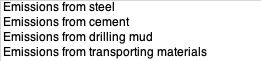

These will be considered in the following sections.

## 4.1 Emissions from steel

## 4.2 Emissions from cement

## 4.3 Emissions from drilling mud

## 4.4 Emissions from transporting materials

# 5. "Other" Offsite Emissions

# 6. Small Sources of Emissions